In [1]:
# import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score,ConfusionMatrixDisplay,accuracy_score

In [2]:
# read the dataset
df = pd.read_csv("Assignment 3_Q1 diabetes_health_indicators_data.csv")

In [3]:
# get 20000 sample 
df = df.sample(20000,random_state=42)

In [4]:
# display top 5 rows
df.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
186913,0,1,1,1,23,0,0,1,1,1,...,1,0,3,0,0,0,1,13,6,5
239126,0,1,1,1,34,1,0,0,1,1,...,1,0,3,0,0,0,0,10,4,7
184226,0,0,1,0,27,0,0,0,1,1,...,1,0,2,3,0,0,0,3,6,8
232560,0,1,0,1,23,0,0,0,1,1,...,1,0,1,1,0,0,0,9,5,8
224748,0,0,0,1,22,1,0,0,1,1,...,1,0,1,0,0,0,0,4,6,8


In [5]:
# check for missing Values
df.isna().sum()

Diabetes                0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [6]:
# get X and y
X = df.drop('Diabetes',axis=1).values
y = df['Diabetes'].values

In [7]:
# split the data into train and test i.e 80:20

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [8]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
# store all the model classificers
models = {
    "RandomForest": RandomForestClassifier (random_state = 42),
    "DecisionTree": DecisionTreeClassifier(random_state = 42),
    "Bagging": BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=1),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=1), 
}

In [10]:
# function to return various performance measure
def perf_measure (y_true, y_pred):
    
    all_per_list  = []
    
    # compute accuracy,recall, precision,f1-score and AUC
    all_per_list.append (accuracy_score (y_true, y_pred))
    all_per_list.append (recall_score (y_true, y_pred))
    all_per_list.append (precision_score (y_true, y_pred))
    all_per_list.append (f1_score (y_true, y_pred))
    all_per_list.append (roc_auc_score (y_true, y_pred))
    
    return all_per_list

In [11]:
y_pred = {} # store y_predicted 
cm = {}  # store confusion  matrix 
Perf_per_algorithm = {} # store performance measure

# iterate through all the models
for model_name, clf in tqdm(models.items ()):
    
    # train the model
    clf.fit (X_train, y_train)
    
    # perform prediction on test set
    y_pred [model_name] = clf.predict (X_test)
    
    # store performance measure in Perf_per_algorithm dictionary where model_name is key
    Perf_per_algorithm [model_name] = perf_measure (y_test,  y_pred [model_name])
    
    # store confusion matrix
    cm [model_name] = confusion_matrix (y_test,y_pred [model_name], normalize ="true")

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
# create a result dataframe from Perf_per_algorithm
result = pd.DataFrame.from_dict(Perf_per_algorithm, orient='index', 
                       columns=['Accuracy', 'Recall', 'Precision', 'F1', 'AUC'])

result

,Accuracy,Recall,Precision,F1,AUC
RandomForest,0.86375,0.175043,0.594118,0.270415,0.577443
DecisionTree,0.79225,0.331023,0.300314,0.314922,0.600510
Bagging,0.85625,0.199307,0.504386,0.285714,0.583147
AdaBoost,0.85175,0.233969,0.472028,0.312862,0.594928


------------RandomForest-----------


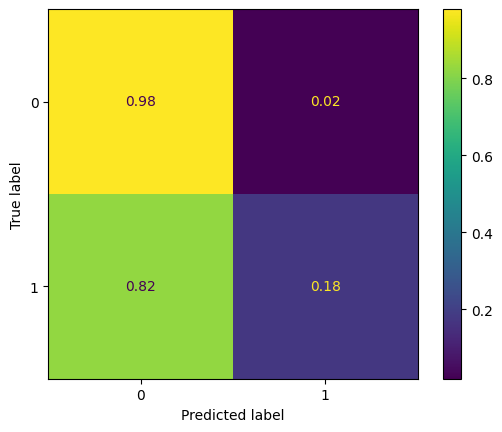

------------DecisionTree-----------


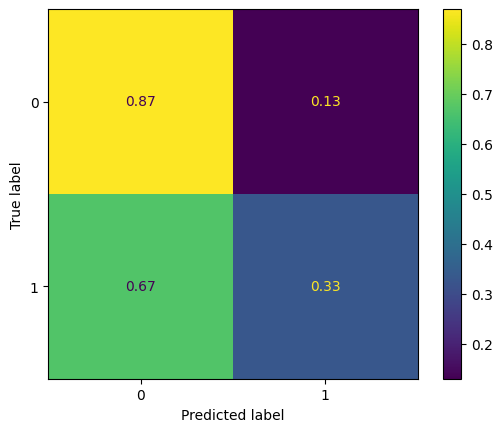

------------Bagging-----------


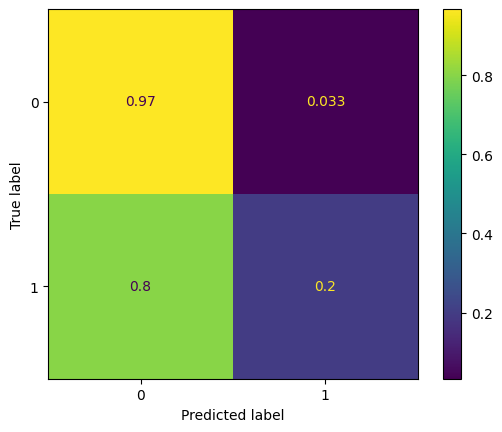

------------AdaBoost-----------


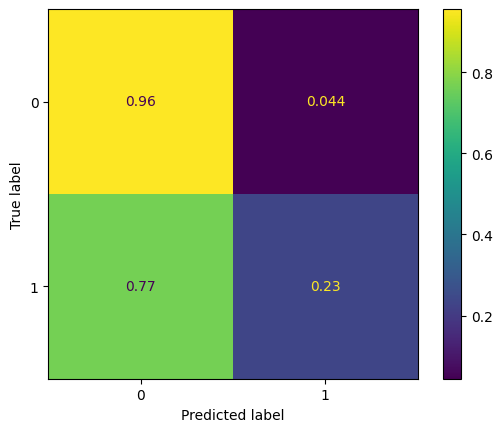

In [13]:
# display confusion matrix
for name,confusion in cm.items():
    print(f"------------{name}-----------")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                                  display_labels=[0,1])
    disp.plot()
    plt.show()

# Grid Search

In [14]:
#define DecisionTree parameters 
parm_DT = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3]}

# create GridSearchCV model
grid_model_DT = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                             parm_DT, verbose=2, cv=3, scoring= 'roc_auc',n_jobs=-1)

In [15]:
# train the model
grid_model_DT.fit(X_train, y_train)

# get best estimator
best_estimator = grid_model_DT.best_estimator_

# train the DecisionTreeClassifier on best estimator
best_estimator.fit (X_train, y_train)

# perform the prediction 
y_pred = best_estimator.predict (X_test)

# store performance measure in Perf_per_algorithm dictionary where model_name is key
Perf_per_algorithm [model_name] = perf_measure (y_test,  y_pred)

# create a result dataframe from Perf_per_algorithm
result = pd.DataFrame.from_dict(Perf_per_algorithm, orient='index', 
                       columns=['Accuracy', 'Recall', 'Precision', 'F1', 'AUC'])

result

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,Accuracy,Recall,Precision,F1,AUC
RandomForest,0.86375,0.175043,0.594118,0.270415,0.577443
DecisionTree,0.79225,0.331023,0.300314,0.314922,0.600510
Bagging,0.85625,0.199307,0.504386,0.285714,0.583147
AdaBoost,0.85575,0.000000,0.000000,0.000000,0.500000


- based on the result , its safe to say that DecisionTree is the best performing model with AUC score of 0.600